In [1]:
#pip install lark-parser

In [2]:
#pip install lark-parser
#pip install pydot
#pip install pillow

from lark import Lark,Tree, Token
import pydot
from PIL import Image
from functools import reduce

process_grammar = r"""
?start: xor

?xor: parallel
    | xor "^" parallel -> xor
    | xor "^" "[" NAME "]" parallel -> xor_probability

?parallel: sequential
    | parallel "||" sequential  -> parallel

?sequential: region
    | sequential "," region -> sequential

?region: 
     | NAME   -> task
     | "(" xor ")"

%import common.CNAME -> NAME
%import common.NUMBER
%import common.WS_INLINE

%ignore WS_INLINE
"""

l = Lark(process_grammar, parser='lalr')
def get_tasks(t):
    trees = [subtree for subtree in t.iter_subtrees()]
    v = {subtree.children[0].value for subtree in   filter(lambda x: x.data == 'task', trees)}
    return v

def dot_tree(t, id=0, prob={}, imp={}):
    if type(t) == Token:
        label = (t.value)
        impact =  f", {imp[label]}" if label in imp  else  ""  
        return f'node_{id}[label="{label}{impact}"];', id
    if type(t) == Tree:
        label = (t.data)
        code = ""
        last_id = id
        child_ids = []
        for i, c in enumerate(t.children):
            dot_code, last_id = dot_tree(c, last_id, prob, imp)
            code += f'\n {dot_code}'
            child_ids.append(last_id)
            last_id += 1
        code += f'\n node_{last_id}[label="{label}"];'
        edge_labels = ['','',''] 
        if label == "xor_probability":
            prob_key = t.children[1].value
            edge_labels = [f'{prob[prob_key] if prob_key  in prob else 0.5 }','',
                           f'{1 - prob[prob_key] if prob_key  in prob else 0.5 }'] 
        for ei,i in enumerate(child_ids):
            edge_label = edge_labels[ei]
            code += f'\n node_{last_id} -> node_{i} [label="{edge_label}"];'
        return code, last_id  

def print_tree(tree, outfile="New.png"):
    dot_string = "digraph my_graph{"+ tree[0] +"}"
    graphs = pydot.graph_from_dot_data(dot_string)
    graph = graphs[0]
    graph.write_png(outfile)
    return Image.open(outfile)
         

In [3]:
Process1 = "(((T1 , ((T2 , (T3 , T4)) ^ (T5 ^  T6))) , ((T7 , (T8 || T9)) || T10)) ^  ((T11 ^ T12) || T13))"

Process2 = "((((T1 ^ T2) , (T3 , T4)) , T5) ^T6)"

Process3 = "((((T1 || (T2 , (T3 ^ T4))) ^ (T5 , T6)) , T7) , (((((T8 , T9) || (T10 || ((T11 ^ T12) , T13))) || T14) , (T15 , T16)) || (((T17 || T18) || (T19 , T20)) || (T21 || (T22 , ((T23 ^ T24) || T25))))))"






In [4]:
Process1t = l.parse(Process1)
Process2t = l.parse(Process2)
Process3t = l.parse(Process3)


In [5]:
#pip install lark-parser
#pip install pydot
#pip install pillow


In [6]:
from lark import Lark, Tree, Token
import pydot
from PIL import Image

process_grammar = r"""
?start: xor

?xor: parallel
    | xor "^" parallel           -> xor
    | xor "^" "[" NAME "]" parallel -> xor_probability

?parallel: sequential
    | parallel "||" sequential  -> parallel

?sequential: region
    | sequential "," region -> sequential

?region: 
     | NAME   -> task
     | "(" xor ")"

%import common.CNAME -> NAME
%import common.NUMBER
%import common.WS_INLINE

%ignore WS_INLINE
"""

l = Lark(process_grammar, parser='lalr')

# Example: parse Process1 (ensure you have defined Process1 as in your snippet)
Process1 = "(((T1 , ((T2 , (T3 , T4)) ^ (T5 ^ T6))) , ((T7 , (T8 || T9)) || T10)) ^  ((T11 ^T12) || T13))"
process_tree = l.parse(Process1)
print(process_tree.pretty())


xor
  sequential
    sequential
      task	T1
      xor
        sequential
          task	T2
          sequential
            task	T3
            task	T4
        xor
          task	T5
          task	T6
    parallel
      sequential
        task	T7
        parallel
          task	T8
          task	T9
      task	T10
  parallel
    xor
      task	T11
      task	T12
    task	T13



In [7]:
# Visualize Process1
dot_code, _ = dot_tree(process_tree)
dot_string = "digraph my_graph{" + dot_code + "}"
graphs = pydot.graph_from_dot_data(dot_string)
graph = graphs[0]
graph.write_png("Process1.png")

# Open the image (this will open the image if you are in an environment that supports it)
Image.open("Process1.png").show()


In [8]:
# For demonstration, assign arbitrary risk values for each task.
# In a more detailed experiment, you could assign likelihood and severity separately.
task_risks = {
    "T1": 0.03,
    "T2": 0.45,
    "T3": 0.04,
    "T4": 0.10,
    "T5": 0.06,
    "T6": 0.08,
    "T7": 0.05,
    "T8": 0.07,
    "T9": 0.09,
    "T10": 0.11,
    "T11": 0.03,
    "T12": 0.04,
    "T13": 0.02,
    # Extend assignments for T14, T15, etc. if needed.
}


In [9]:
def compound_risk(r1, r2):
    return r1 + r2 - (r1 * r2)


In [10]:
print("Compound risk of 0.03 and 0.45:", compound_risk(0.03, 0.45))


Compound risk of 0.03 and 0.45: 0.46649999999999997


In [11]:
def compute_trace_risk(risks):
    return reduce(compound_risk, risks)

# Example for tasks T3, T4, T5, T6 in a trace:
trace_risks = [task_risks["T3"], task_risks["T4"], task_risks["T5"], task_risks["T6"]]
print("Trace risk:", compute_trace_risk(trace_risks))


Trace risk: 0.2528128


In [12]:
# XOR: (Risk_A ^[p] Risk_B)
def xor_risk(risk_a, risk_b, p=0.5, mode="weighted"):
    if mode == "weighted":
        # Compute weighted risk: p * risk_a + (1-p) * risk_b
        return p * risk_a + (1 - p) * risk_b
    elif mode == "min":
        return min(risk_a, risk_b)
    elif mode == "max":
        return max(risk_a, risk_b)



In [13]:
def compute_node_risk(node, mode="weighted"):
    """
    Recursively compute the risk for a given node in the parse tree.
    'mode' can be used to choose how XOR risks are combined.
    """
    # If node is a Token (i.e., a task name)
    if isinstance(node, Token):
        # Assume token.value is the task name (e.g., "T1")
        return task_risks.get(node.value, 0)  # default risk 0 if not defined

    # If node is a Tree, use the node's data attribute:
    if isinstance(node, Tree):
        # Handle different types of nodes based on the production rule:
        if node.data == "task":
            # A task node: its child is a Token with the task name.
            return compute_node_risk(node.children[0])
        elif node.data == "sequential":
            # Sequential: compound risk of all children in order.
            risks = [compute_node_risk(child, mode) for child in node.children]
            return compute_trace_risk(risks)
        elif node.data == "parallel":
            # For parallel, here we simply compound them.
            risks = [compute_node_risk(child, mode) for child in node.children]
            return compute_trace_risk(risks)
        elif node.data == "xor":
            # For an XOR with no probability annotation, choose (for example) the minimum risk.
            risks = [compute_node_risk(child, mode) for child in node.children]
            return min(risks)
        elif node.data == "xor_probability":
            # Structure: left subtree, probability token, right subtree.
            left_risk = compute_node_risk(node.children[0], mode)
            # node.children[1] is the probability token (e.g., p1)
            # For simplicity, look up the probability from a dictionary:
            prob_key = node.children[1].value
            # If you have a dictionary for probabilities (p1, p2, etc.), use it:
            probabilities = {"p1": 0.6, "p2": 0.5, "p3": 0.7, "p4": 0.8, "p5": 0.55, "p6": 0.5}
            p = probabilities.get(prob_key, 0.5)
            right_risk = compute_node_risk(node.children[2], mode)
            return xor_risk(left_risk, right_risk, p=p, mode=mode)
        else:
            # For any other nonterminal: compute risk for all children and compound them.
            risks = [compute_node_risk(child, mode) for child in node.children]
            return compute_trace_risk(risks)
    return 0

# Example: compute risk for Process1
risk_process1 = compute_node_risk(process_tree, mode="weighted")
print("Computed risk for Process1:", risk_process1)


Computed risk for Process1: 0.0494


By following these steps you will have:

1, Parsed your BPMN process strings using Lark.
2, Visualized the BPMN structures using pydot and Pillow.
3, Assigned risk parameters and implemented compound risk calculations.
4, Traversed the parse trees to compute the overall risk of each process.
5, Conducted experiments to verify correctness, perform sensitivity analysis, and assess performance.

In [14]:
from lark import Lark, Tree, Token
import pydot
from PIL import Image
from functools import reduce

# --- Define the Grammar (as before) ---
process_grammar = r"""
?start: xor

?xor: parallel
    | xor "^" parallel           -> xor
    | xor "^" "[" NAME "]" parallel -> xor_probability

?parallel: sequential
    | parallel "||" sequential  -> parallel

?sequential: region
    | sequential "," region -> sequential

?region: 
     | NAME   -> task
     | "(" xor ")"

%import common.CNAME -> NAME
%import common.NUMBER
%import common.WS_INLINE

%ignore WS_INLINE
"""

l = Lark(process_grammar, parser='lalr')

# --- Define a simple risk model ---
# For demonstration, we assign arbitrary risk values to tasks.
task_risks = {
    "T1": 0.03,
    "T2": 0.45,
    "T3": 0.04,
    "T4": 0.10,
    "T5": 0.06,
    "T6": 0.08,
    "T7": 0.05,
    "T8": 0.07,
    "T9": 0.09,
    "T10": 0.11,
    "T11": 0.03,
    "T12": 0.04,
    "T13": 0.02,
    # Add additional tasks as needed.
}

# Probability dictionary for XOR probability annotations
probabilities = {"p1": 0.6, "p2": 0.5, "p3": 0.7, "p4": 0.8, "p5": 0.55, "p6": 0.5}

# --- Define risk-computation functions ---
def compound_risk(r1, r2):
    """Compound two risk values according to the formula:
       r(a, b) = r1 + r2 - r1 * r2"""
    return r1 + r2 - (r1 * r2)

def compute_trace_risk(risks):
    """Compute compound risk for a list of risk values."""
    return reduce(compound_risk, risks)

def xor_risk(risk_a, risk_b, p=0.5, mode="weighted"):
    """
    For an XOR node, compute the risk based on probability.
    mode can be:
      - "weighted": weighted sum,
      - "min": choose the lower risk,
      - "max": choose the higher risk.
    """
    if mode == "weighted":
        return p * risk_a + (1 - p) * risk_b
    elif mode == "min":
        return min(risk_a, risk_b)
    elif mode == "max":
        return max(risk_a, risk_b)
    else:
        return p * risk_a + (1 - p) * risk_b

def compute_node_risk(node, mode="weighted"):
    """
    Recursively compute the risk for a given node in the parse tree.
    The rules are:
      - A task node: lookup its risk from task_risks.
      - Sequential and parallel: compound the risks.
      - XOR: use min (or weighted) rule.
    """
    if isinstance(node, Token):
        # Return the risk value for a task token.
        return task_risks.get(node.value, 0)
    
    if isinstance(node, Tree):
        if node.data == "task":
            # A task node: its child is a Token with the task name.
            return compute_node_risk(node.children[0], mode)
        elif node.data == "sequential":
            risks = [compute_node_risk(child, mode) for child in node.children]
            return compute_trace_risk(risks)
        elif node.data == "parallel":
            # For parallel, we simply compound the risks (or choose an alternative rule)
            risks = [compute_node_risk(child, mode) for child in node.children]
            return compute_trace_risk(risks)
        elif node.data == "xor":
            risks = [compute_node_risk(child, mode) for child in node.children]
            # Here we choose the minimum risk as a lower bound.
            return min(risks)
        elif node.data == "xor_probability":
            # For structure: left subtree, probability token, right subtree.
            left_risk = compute_node_risk(node.children[0], mode)
            prob_key = node.children[1].value
            p = probabilities.get(prob_key, 0.5)
            right_risk = compute_node_risk(node.children[2], mode)
            return xor_risk(left_risk, right_risk, p=p, mode=mode)
        else:
            # Default: compound the risks of all children.
            risks = [compute_node_risk(child, mode) for child in node.children]
            return compute_trace_risk(risks)
    return 0

# --- Modify dot_tree to include computed risk information ---
def dot_tree(node, node_id=0):
    """
    Recursively produce DOT code for the tree, annotating each node with its computed risk.
    Returns a tuple (dot_code, next_available_id).
    """
    dot_code = ""
    current_id = node_id

    if isinstance(node, Token):
        # For a token node, annotate with its risk (if any)
        risk_val = compute_node_risk(node)
        label = f"{node.value}\nRisk: {risk_val:.3f}"
        dot_code += f'node_{current_id} [label="{label}"];'
        return dot_code, current_id

    elif isinstance(node, Tree):
        # Compute the risk for the current subtree.
        risk_val = compute_node_risk(node)
        label = f"{node.data}\nRisk: {risk_val:.3f}"
        dot_code += f'node_{current_id} [label="{label}"];'
        root_id = current_id
        current_id += 1

        child_ids = []
        # Process each child recursively.
        for child in node.children:
            child_code, current_id = dot_tree(child, current_id)
            dot_code += "\n" + child_code
            child_ids.append(current_id)  # record the child's node id (approx.)
            current_id += 1

        # Now add edges from the current node to each child.
        # (For XOR with probability, we add special edge labels)
        if node.data == "xor_probability" and len(node.children) >= 3:
            # Expecting structure: left, probability token, right.
            # Edge from current node to left child: label = probability p.
            left_child_id = root_id + 1
            right_child_id = left_child_id + 1  # this is a simplification
            p = probabilities.get(node.children[1].value, 0.5)
            dot_code += f'\nnode_{root_id} -> node_{left_child_id} [label="{p:.2f}"];'
            dot_code += f'\nnode_{root_id} -> node_{right_child_id} [label="{1-p:.2f}"];'
        else:
            # For other node types, add an edge for each child.
            # (Here we do not differentiate edge labels.)
            for child_index, child in enumerate(node.children):
                # Use an empty label for now.
                dot_code += f'\nnode_{root_id} -> node_{root_id+1+child_index} [label=""];'
        return dot_code, current_id

# --- Function to render and display the DOT graph ---
def print_tree(tree, outfile="Process1.png"):
    dot_code, _ = dot_tree(tree)
    dot_string = "digraph my_graph{" + dot_code + "}"
    graphs = pydot.graph_from_dot_data(dot_string)
    graph = graphs[0]
    graph.write_png(outfile)
    return Image.open(outfile)

# --- Parse Process1 and visualize it ---
Process1 = "(((T1 , ((T2 , (T3 , T4)) ^[p1] (T5 ^[p2] T6))) , ((T7 , (T8 || T9)) || T10)) ^ [p3] ((T11 ^[p4] T12) || T13))"
process1_tree = l.parse(Process1)

# Visualize Process1 with risk annotations:
img = print_tree(process1_tree, "Process1_Risk.png")
img.show()


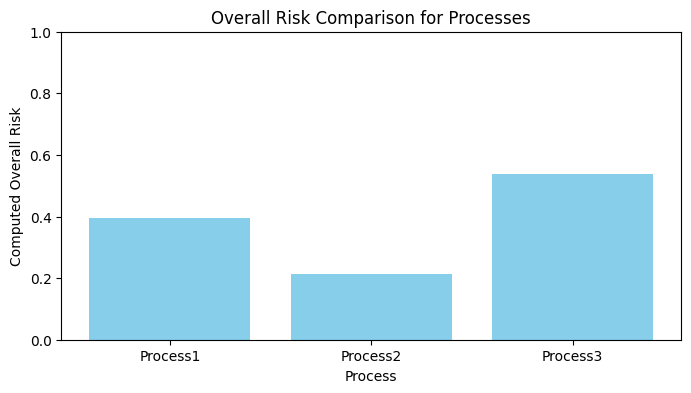

In [15]:
import matplotlib.pyplot as plt

# Define your process strings (here we use a few for demonstration)
Process2 = "((((T1 ^[p1] T2) , (T3 , T4)) , T5) ^[p2]T6)"
Process3 = "((((T1 || (T2 , (T3 ^[p1] T4))) ^[p2] (T5 , T6)) , T7) , (((((T8 , T9) || (T10 || ((T11 ^[p3] T12) , T13))) || T14) , (T15 , T16)) || (((T17 || T18) || (T19 , T20)) || (T21 || (T22 , ((T23 ^[p4] T24) || T25))))))"

processes = {
    "Process1": Process1,
    "Process2": Process2,
    "Process3": Process3,
    # add other processes if desired...
}

# Compute overall risk for each process
process_risks = {}
for name, proc_str in processes.items():
    tree = l.parse(proc_str)
    risk_val = compute_node_risk(tree, mode="weighted")
    process_risks[name] = risk_val

# Create a bar chart
plt.figure(figsize=(8, 4))
names = list(process_risks.keys())
values = [process_risks[name] for name in names]
plt.bar(names, values, color='skyblue')
plt.xlabel("Process")
plt.ylabel("Computed Overall Risk")
plt.title("Overall Risk Comparison for Processes")
plt.ylim(0, 1)  # assuming risk values are between 0 and 1
plt.show()


In [23]:
import random
from PIL import Image
from IPython.display import display
from random_diagram_generation import SEED_STRING, replace_random_underscore, replace_underscores, guess_three_numbers
from sese_diagram import PARSER, print_sese_diagram, print_tree, dot_tree
from stats import max_nested_xor, max_independent_xor
from generate_impacts import generate_vectors
from utils import find_max_task_number,get_process_from_file,array_to_list_string

# Function to generate a random business process
def generate_random_process():
    nested = random.randint(1, 4)  # Random nested level between 1 and 3
    independent = random.randint(1, 4)  # Random independent level between 1 and 3
    process_number = random.randint(1, 4)  # Random process number between 1 and 3
    return get_process_from_file(nested, independent, process_number)

# Dimension for impact vectors
dimension = 3  # Number of dimensions for impact vectors

# Generate 10 random business processes
random_processes = [generate_random_process() for _ in range(100)]

# Process each generated business process
for i, process in enumerate(random_processes, start=1):
    print(f"\nGenerated Process {i}:")
    print(process)  # Assuming process has a meaningful __str__ or __repr__ method

    # Find the maximum number of tasks in the process
    num_tasks = find_max_task_number(process)

    # Generate impact vectors for the tasks
    vectors = generate_vectors(num_tasks, dimension, mode="Bagging Remove Reverse Divide")  # Adjust mode if needed
    impacts = {f"T{j+1}": vector.tolist() for j, vector in enumerate(vectors)}

    # Add impacts to the SESE diagram and generate the updated image
    image = print_sese_diagram(
        process,
        impacts=impacts,
        impacts_names=[f"Impact {k+1}" for k in range(dimension)]
    )
    
    # Display the SESE diagram with impact measures
    #display(image)

    # Print a separator for clarity
    print(f"\n{'-' * 40}\n")



Generated Process 1:
(((T1 , T2) , ((T3 , T4) ^ (T5 , T6))) || (T7 , ((T8 || T9) , (((T10 ^ T11) , T12) , (T13 ^ T14)))))

----------------------------------------


Generated Process 2:
((T1 ^ (T2 || (((T3 ^ T4) ^ T5) || T6))) , ((T7 ^ (T8 , T9)) ^ ((((T10 , T11) , T12) ^ T13) || (T14 || T15))))

----------------------------------------


Generated Process 3:
(((T1 , T2) ^ (((T3 ^ T4) , T5) , (T6 ^ T7))) || ((((T8 || T9) || (T10 , (T11 || T12))) , (((T13 ^ T14) , T15) ^ T16)) , (T17 || (T18 ^ T19))))

----------------------------------------


Generated Process 4:
((((((T1 , T2) , T3) , T4) || T5) || (T6 ^ (((T7 , ((T8 , (T9 ^ T10)) ^ (T11 , T12))) , T13) , T14))) ^ ((T15 || (T16 || (((T17 , T18) , T19) ^ (T20 || T21)))) , T22))

----------------------------------------


Generated Process 5:
((T1 || ((T2 , T3) , ((((T4 ^ T5) || T6) ^ (T7 || ((T8 , T9) ^ T10))) || ((((T11 , T12) || (T13 ^ T14)) , ((T15 || (T16 || T17)) ^ T18)) ^ T19)))) ^ (T20 || ((T21 , T22) ^ (T23 , (T24 ^ ((T25 , 

a Python script that generates risk values for different tasks using different modes. It assigns Likelihood (λ) and Severity (σ) values between 0 and 1, then computes the Risk (r) using the formula:


r(e)=λ(e)×σ(e)
The script supports multiple modes to generate risk values in a structured and reasonable way:

Low Risk Mode: Likelihood and severity are generally low.
Medium Risk Mode: Likelihood and severity have moderate values.
High Risk Mode: Likelihood and severity are relatively high.
Mixed Risk Mode: A mix of different risk levels to represent a real-world scenario.


In [24]:
import random

def generate_risk_values(mode="mixed"):
    """
    Generate risk values based on the specified mode.
    
    Modes:
    - "low": Low likelihood and severity values (small risk).
    - "medium": Moderate likelihood and severity values.
    - "high": High likelihood and severity values.
    - "mixed": A mix of low, medium, and high risks.
    """
    
    task_risks = {}
    tasks = [f"T{i}" for i in range(1, 38)]  # Generate tasks T1 to T13
    
    for task in tasks:
        if mode == "low":
            λ = round(random.uniform(0.01, 0.3), 2)  # Small likelihood
            σ = round(random.uniform(0.01, 0.3), 2)  # Small severity
        
        elif mode == "medium":
            λ = round(random.uniform(0.3, 0.6), 2)  # Moderate likelihood
            σ = round(random.uniform(0.3, 0.6), 2)  # Moderate severity
        
        elif mode == "high":
            λ = round(random.uniform(0.6, 1.0), 2)  # High likelihood
            σ = round(random.uniform(0.6, 1.0), 2)  # High severity
        
        elif mode == "mixed":
            if random.random() < 0.33:  # 33% chance of low risk
                λ = round(random.uniform(0.01, 0.3), 2)
                σ = round(random.uniform(0.01, 0.3), 2)
            elif random.random() < 0.66:  # 33% chance of medium risk
                λ = round(random.uniform(0.3, 0.6), 2)
                σ = round(random.uniform(0.3, 0.6), 2)
            else:  # 33% chance of high risk
                λ = round(random.uniform(0.6, 1.0), 2)
                σ = round(random.uniform(0.6, 1.0), 2)
        
        # Compute the risk
        r = round(λ * σ, 3)
        task_risks[task] = {"Likelihood (λ)": λ, "Severity (σ)": σ, "Risk (r)": r}
    
    return task_risks

# Example: Generate risk values for different modes
modes = ["low", "medium", "high", "mixed"]
for mode in modes:
    print(f"\nRisk values in {mode.upper()} mode:")
    task_risks = generate_risk_values(mode)
    for task, values in task_risks.items():
        print(f"{task}: {values}")



Risk values in LOW mode:
T1: {'Likelihood (λ)': 0.28, 'Severity (σ)': 0.07, 'Risk (r)': 0.02}
T2: {'Likelihood (λ)': 0.16, 'Severity (σ)': 0.22, 'Risk (r)': 0.035}
T3: {'Likelihood (λ)': 0.22, 'Severity (σ)': 0.11, 'Risk (r)': 0.024}
T4: {'Likelihood (λ)': 0.04, 'Severity (σ)': 0.1, 'Risk (r)': 0.004}
T5: {'Likelihood (λ)': 0.07, 'Severity (σ)': 0.11, 'Risk (r)': 0.008}
T6: {'Likelihood (λ)': 0.19, 'Severity (σ)': 0.06, 'Risk (r)': 0.011}
T7: {'Likelihood (λ)': 0.12, 'Severity (σ)': 0.13, 'Risk (r)': 0.016}
T8: {'Likelihood (λ)': 0.05, 'Severity (σ)': 0.12, 'Risk (r)': 0.006}
T9: {'Likelihood (λ)': 0.02, 'Severity (σ)': 0.03, 'Risk (r)': 0.001}
T10: {'Likelihood (λ)': 0.02, 'Severity (σ)': 0.03, 'Risk (r)': 0.001}
T11: {'Likelihood (λ)': 0.17, 'Severity (σ)': 0.01, 'Risk (r)': 0.002}
T12: {'Likelihood (λ)': 0.15, 'Severity (σ)': 0.26, 'Risk (r)': 0.039}
T13: {'Likelihood (λ)': 0.19, 'Severity (σ)': 0.22, 'Risk (r)': 0.042}
T14: {'Likelihood (λ)': 0.06, 'Severity (σ)': 0.24, 'Risk (r)'

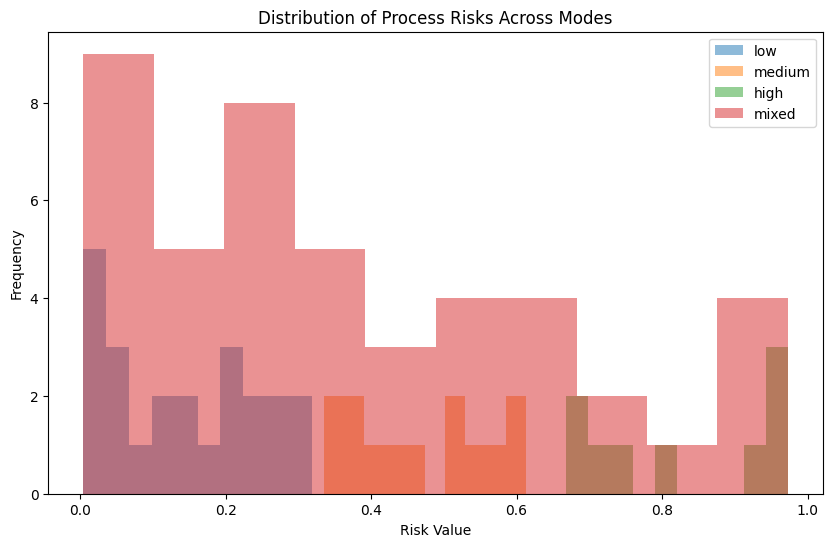

Mode: low
Top 10 Lowest Risk Processes:
  Process_3: 0.0043
  Process_31: 0.0102
  Process_1: 0.0131
  Process_38: 0.0263
  Process_34: 0.0297
  Process_22: 0.0372
  Process_32: 0.0570
  Process_24: 0.0579
  Process_15: 0.0776
  Process_25: 0.1112

Top 10 Highest Risk Processes:
  Process_11: 0.1790
  Process_27: 0.2091
  Process_7: 0.2156
  Process_23: 0.2178
  Process_37: 0.2248
  Process_16: 0.2355
  Process_14: 0.2602
  Process_45: 0.2689
  Process_6: 0.2926
  Process_36: 0.3183

----------------------------------------

Mode: medium
Top 10 Lowest Risk Processes:
  Process_28: 0.3351
  Process_26: 0.3455
  Process_21: 0.3751
  Process_43: 0.3859
  Process_18: 0.4113
  Process_10: 0.4279
  Process_40: 0.4728
  Process_17: 0.5052
  Process_20: 0.5189
  Process_42: 0.5324

Top 10 Highest Risk Processes:
  Process_43: 0.3859
  Process_18: 0.4113
  Process_10: 0.4279
  Process_40: 0.4728
  Process_17: 0.5052
  Process_20: 0.5189
  Process_42: 0.5324
  Process_9: 0.5717
  Process_41: 0.6

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to compute risk for a given process
# This is a placeholder function; replace it with actual risk computation logic
def compute_risk(process):
    return np.random.uniform(0, 1)  # Random risk value between 0 and 1

# Define process modes
modes = ['low', 'medium', 'high', 'mixed']

# Define the processes
processes = [
    "(((T1 , ((T2 , (T3 , T4)) ^[p1] (T5 ^[p2] T6))) , ((T7 , (T8 || T9)) || T10)) ^[p3] ((T11 ^[p4] T12) || T13))",
    "(((T1 || (T2 ^[p1] T3)) || T4) || ((T5 ^[p2] (T6 ^[p3] T7)) ^[p4] T8))",
    "((((T1 ^[p1] T2) , T3) ^[p2] ((T4 || (T5 ^[p3] T6)) , (T7 ^[p4] T8))) || ((T9 , (T10 ^[p5] T11)) || (T12 ^[p6] T13)))",
    "(((T1 ^[p1] (T2 , T3)) ^[p2] ((T4 , T5) || T6)) ^[p3] (((T7 ^[p4] T8) , (T9 ^[p5] (T10 ^[p6] (T11 ^[p7] T12)))) , (((T13 || T14) || ((T15 , (T16 ^[p8] T17)) || (T18 ^[p9] T19))) , T20)))",
    "(((((T1 , (T2 || T3)) || T4) , ((T5 , T6) , T7)) , (((T8 , (T9 || T10)) ^[p1] ((T11 , T12) ^[p2] (T13 ^[p3] T14))) , T15)) , (((T16 , T17) || (((((T18 || T19) ^[p4] T20) , T21) , (T22 ^[p5] T23)) ^[p6] (T24 ^[p7] T25))) || (((T26 || ((T27 || T28) || T29)) ^[p8] (T30 , T31)) , T32)))",
    "(((((T1 , T2) , T3) ^[p1] ((T4 , T5) , T6)) || ((T7 || T8) || T9)) || (((((T10 ^[p2] T11) || (T12 , (T13 ^[p3] T14))) ^[p4] T15) , (T16 ^[p5] T17)) , T18))",
    "((((T1 || T2) , (T3 || T4)) || ((T5 , T6) ^[p1] T7)) || (((T8 || ((T9 || T10) ^[p2] T11)) , ((((T12 , T13) , (T14 ^[p3] T15)) , T16) , ((T17 || T18) ^[p4] T19))) , ((T20 , T21) , (T22 , T23))))",
    "(((T1 ^[p1] (T2 , T3)) ^[p2] ((T4 , T5) || T6)) ^[p3] (((T7 ^[p4] T8) , (T9 ^[p5] (T10 ^[p6] (T11 ^[p7] T12)))) , (((T13 || T14) || ((T15 , (T16 ^[p8] T17)) || (T18 ^[p9] T19))) , T20)))",
    "(((((T1 , T2) , T3) , (T4 ^[p1] T5)) , (((T6 || (T7 ^[p2] T8)) , (T9 , T10)) , T11)) , ((T12 , T13) , T14))",
    "((T1 || ((T2 , T3) , ((((T4 ^[p1] T5) || T6) ^[p2] (T7 || ((T8 , T9) ^[p3] T10))) || ((((T11 , T12) || (T13 ^[p4] T14)) , ((T15 || (T16 || T17)) ^[p5] T18)) ^[p6] T19)))) ^[p7] (T20 || ((T21 , T22) ^[p8] (T23 , (T24 ^[p9] ((T25 , T26) || T27))))))",
    "(((T1 ^[p1] T2) , T3) , ((T4 ^[p2] (T5 ^[p3] T6)) , T7))",
    "((T1 || (T2 ^[p1] (T3 ^[p2] T4))) , (T5 || ((T6 , T7) , ((T8 || T9) , T10))))",
    "(((T1 ^[p1] (T2 , T3)) , T4) ^[p2] ((T5 ^[p3] (T6 ^[p4] T7)) ^[p5] (T8 , T9)))",
    "(((((T1 , T2) || T3) , ((T4 || T5) || (T6 || T7))) , T8) || ((((T9 || T10) , ((T11 ^[p1] T12) ^[p2] T13)) || (T14 , (((((T15 , T16) ^[p3] T17) || (T18 || T19)) || ((T20 , ((T21 ^[p4] T22) || T23)) ^[p5] (T24 , (T25 , (((T26 || (T27 || T28)) , (T29 , T30)) ^[p6] (T31 ^[p7] T32)))))) , (T33 ^[p8] T34)))) ^[p9] (T35 , (T36 , T37))))",
    "((((T1 ^[p1] T2) , (T3 , T4)) , T5) ^[p2] T6)",
    "((((T1 , T2) || ((T3 ^[p1] T4) || T5)) || (((T6 || T7) , T8) ^[p2] (T9 || T10))) || (T11 || (T12 || T13)))",
    "(((T1 , ((T2 , (T3 , T4)) ^[p1] (T5 ^[p2] T6))) , ((T7 , (T8 || T9)) || T10)) ^[p3] ((T11 ^[p4] T12) || T13))",
    "((T1 || (T2 ^[p1] (T3 ^[p2] T4))) , (T5 || ((T6 , T7) , ((T8 || T9) , T10))))",
    "(((T1 , T2) ^[p1] (T3 , T4)) , ((((((T5 ^[p2] T6) , T7) || T8) ^[p3] T9) || (T10 ^[p4] T11)) ^[p5] T12))",
    "(((T1 ^[p1] (T2 , T3)) ^[p2] ((T4 , T5) || T6)) ^[p3] (((T7 ^[p4] T8) , (T9 ^[p5] (T10 ^[p6] (T11 ^[p7] T12)))) , (((T13 || T14) || ((T15 , (T16 ^[p8] T17)) || (T18 ^[p9] T19))) , T20)))",
    "((((T1 , T2) ^[p1] (((T3 ^[p2] T4) , (T5 , ((T6 , T7) ^[p3] T8))) || ((T9 , (T10 ^[p4] T11)) , T12))) ^[p5] (((T13 , T14) ^[p6] T15) , T16)) || (T17 , T18))",
    "((T1 || T2) ^[p1] (((T3 ^[p2] T4) || (T5 , T6)) || ((T7 , (T8 , T9)) , ((T10 || T11) , T12))))",
    "((T1 ^[p1] T2) , (((T3 ^[p2] T4) ^[p3] (((T5 || (T6 || T7)) , (T8 , (T9 || T10))) || (((T11 , T12) , (T13 || T14)) , T15))) , (T16 || (T17 ^[p4] T18))))",
    "((T1 , ((((T2 ^[p1] T3) || (((T4 , T5) || (T6 , T7)) , T8)) , (T9 , (T10 , (((T11 , T12) || T13) || T14)))) || ((T15 ^[p2] (T16 , T17)) || (T18 || ((T19 || ((T20 ^[p3] (T21 || T22)) , (T23 || T24))) , (T25 , T26)))))) || (((T27 , T28) || ((T29 , T30) , T31)) ^[p4] (T32 , (T33 , T34))))",
    "(((((T1 ^[p1] T2) || (T3 , T4)) , ((T5 || T6) || (T7 , T8))) , (((T9 ^[p2] T10) , (T11 ^[p3] T12)) , (T13 ^[p4] T14))) ^[p5] (T15 ^[p6] (T16 ^[p7] (T17 ^[p8] ((T18 , T19) , T20)))))",
    "((T1 ^[p1] (T2 ^[p2] (T3 , (T4 ^[p3] T5)))) ^[p4] (((((T6 ^[p5] T7) , (T8 || T9)) , ((T10 || T11) , T12)) , (T13 ^[p6] T14)) ^[p7] T15))",
    "((((T1 , ((T2 ^[p1] (T3 , T4)) , (((T5 , T6) , T7) , (((T8 , T9) , (T10 , T11)) , T12)))) || (T13 , (((T14 , T15) , T16) ^[p2] T17))) , T18) , (T19 ^[p3] T20))",
    "(((T1 , T2) , (T3 ^[p1] ((T4 ^[p2] T5) , ((T6 , T7) || T8)))) ^[p3] ((((T9 || T10) , (T11 , T12)) ^[p4] ((T13 , T14) , T15)) , (T16 || ((T17 || T18) || T19))))",
    "(((T1 , T2) ^[p1] (((T3 ^[p2] T4) , T5) , (T6 ^[p3] T7))) || ((((T8 || T9) || (T10 , (T11 || T12))) , (((T13 ^[p4] T14) , T15) ^[p5] T16)) , (T17 || (T18 ^[p6] T19))))",
    "(((((T1 ^[p1] T2) || (T3 , T4)) , ((T5 || T6) || (T7 , T8))) , (((T9 ^[p2] T10) , (T11 ^[p3] T12)) , (T13 ^[p4] T14))) ^[p5] (T15 ^[p6] (T16 ^[p7] (T17 ^[p8] ((T18 , T19) , T20)))))",
    "(((T1 ^[p1] T2) , T3) , ((T4 ^[p2] (T5 ^[p3] T6)) , T7))",
    "((((T1 , T2) ^[p1] (((T3 ^[p2] T4) , (T5 , ((T6 , T7) ^[p3] T8))) || ((T9 , (T10 ^[p4] T11)) , T12))) ^[p5] (((T13 , T14) ^[p6] T15) , T16)) || (T17 , T18))",
    "(((T1 ^[p1] (T2 , T3)) , T4) ^[p2] ((T5 ^[p3] (T6 ^[p4] T7)) ^[p5] (T8 , T9)))",
    "(((T1 , T2) ^[p1] (((T3 || (T4 ^[p2] T5)) ^[p3] (T6 || ((T7 || T8) || T9))) , T10)) , ((T11 ^[p4] (T12 ^[p5] (T13 ^[p6] T14))) ^[p7] ((T15 ^[p8] T16) , T17)))",
    "((((((T1 || T2) , (T3 || (T4 ^[p1] T5))) , (((T6 , T7) || (T8 , T9)) , ((T10 || T11) , T12))) , ((T13 ^[p2] T14) || (T15 , T16))) ^[p3] T17) || (((T18 , ((T19 ^[p4] T20) , T21)) ^[p5] ((T22 || ((T23 || T24) , T25)) ^[p6] T26)) , (T27 , T28)))",
    "((((((T1 ^[p1] T2) ^[p2] T3) , ((((T4 || T5) || T6) , T7) ^[p3] (((T8 || (T9 ^[p4] T10)) , T11) || ((T12 ^[p5] T13) ^[p6] T14)))) || (T15 ^[p7] T16)) , ((T17 , T18) || T19)) , (T20 || T21))",
    "((((T1 , T2) || ((T3 ^[p1] T4) || T5)) || (((T6 || T7) , T8) ^[p2] (T9 || T10))) || (T11 || (T12 || T13)))",
    "((((T1 || (T2 , (T3 ^[p1] T4))) ^[p2] (T5 , T6)) , T7) , (((((T8 , T9) || (T10 || ((T11 ^[p3] T12) , T13))) || T14) , (T15 , T16)) || (((T17 || T18) || (T19 , T20)) || (T21 || (T22 , ((T23 ^[p4] T24) || T25))))))",
    "(((T1 ^[p1] T2) , ((T3 || T4) || ((T5 || (T6 ^[p2] T7)) , T8))) ^[p3] ((T9 || T10) , (T11 || T12)))",
    "((T1 ^[p1] ((T2 , (T3 || (T4 , T5))) , (T6 , T7))) || (((T8 , (T9 , T10)) || T11) , (T12 ^[p2] T13)))",
    "(((T1 ^[p1] T2) , (T3 ^[p2] T4)) , (((T5 , T6) , (T7 , (T8 ^[p3] T9))) || (T10 || (T11 ^[p4] T12))))",
    "((T1 || (T2 || T3)) , (((((T4 || T5) , T6) ^[p1] T7) || (T8 ^[p2] T9)) ^[p3] ((T10 , T11) , (T12 , ((T13 ^[p4] T14) || T15)))))",
    "(((T1 ^[p1] (T2 , T3)) , T4) ^[p2] ((T5 ^[p3] (T6 ^[p4] T7)) ^[p5] (T8 , T9)))",
    "(((T1 , T2) , ((T3 , T4) ^[p1] (T5 , T6))) || (T7 , ((T8 || T9) , (((T10 ^[p2] T11) , T12) , (T13 ^[p3] T14)))))",
    "((T1 || (T2 ^[p1] (T3 ^[p2] T4))) , (T5 || ((T6 , T7) , ((T8 || T9) , T10))))"
]

# Compute risks for each process
#process_risks = {process: compute_risk(expr) for process, expr in processes.items()}
process_risks = {f'Process_{i+1}': compute_risk(expr) for i, expr in enumerate(processes)}


# Categorize processes based on risk levels
categorized_processes = {
    'low': {},
    'medium': {},
    'high': {},
    'mixed': {},
}

for process, risk in process_risks.items():
    if risk < 0.33:
        categorized_processes['low'][process] = risk
    elif risk < 0.66:
        categorized_processes['medium'][process] = risk
    else:
        categorized_processes['high'][process] = risk
    
    categorized_processes['mixed'][process] = risk  # Mixed includes all

# Function to select top 10 and bottom 10 processes based on risk
def select_top_bottom(process_dict):
    sorted_processes = sorted(process_dict.items(), key=lambda x: x[1])
    return sorted_processes[:10], sorted_processes[-10:]

# Store the selected top/bottom 10 for each mode
selected_processes = {}
for mode in modes:
    low_10, high_10 = select_top_bottom(categorized_processes[mode])
    selected_processes[mode] = {
        'low_10': low_10,
        'high_10': high_10,
    }

# Visualization
plt.figure(figsize=(10, 6))
for mode in modes:
    risks = [risk for _, risk in categorized_processes[mode].items()]
    plt.hist(risks, bins=10, alpha=0.5, label=mode)

plt.xlabel('Risk Value')
plt.ylabel('Frequency')
plt.title('Distribution of Process Risks Across Modes')
plt.legend()
plt.show()

# Print selected top and bottom 10 processes per mode
for mode, data in selected_processes.items():
    print(f"Mode: {mode}")
    print("Top 10 Lowest Risk Processes:")
    for process, risk in data['low_10']:
        print(f"  {process}: {risk:.4f}")
    print("\nTop 10 Highest Risk Processes:")
    for process, risk in data['high_10']:
        print(f"  {process}: {risk:.4f}")
    print("\n" + "-" * 40 + "\n")


In [25]:
import random
from PIL import Image
from IPython.display import display
from random_diagram_generation import SEED_STRING, replace_random_underscore, replace_underscores, guess_three_numbers
from sese_diagram import PARSER, print_sese_diagram, print_tree, dot_tree
from stats import max_nested_xor, max_independent_xor
from generate_impacts import generate_vectors
from utils import find_max_task_number, get_process_from_file, array_to_list_string

# Function to generate a random business process
def generate_random_process():
    nested = random.randint(1, 4)  # Random nested level between 1 and 4
    independent = random.randint(1, 4)  # Random independent level between 1 and 4
    process_number = random.randint(1, 4)  # Random process number between 1 and 4
    return get_process_from_file(nested, independent, process_number)

# Dimension for impact vectors
dimension = 3  # Number of dimensions for impact vectors

# Generate 100 random business processes
random_processes = [generate_random_process() for _ in range(100)]

# Dictionary to store process-wise task count
process_task_counts = {}

# Process each generated business process
for i, process in enumerate(random_processes, start=1):
    print(f"\nGenerated Process {i}:")
    print(process)  # Assuming process has a meaningful __str__ or __repr__ method

    # Find the number of tasks in the process
    num_tasks = find_max_task_number(process)
    process_task_counts[f"Process {i}"] = num_tasks  # Store task count

    # Generate impact vectors for the tasks
    vectors = generate_vectors(num_tasks, dimension, mode="Bagging Remove Reverse Divide")  # Adjust mode if needed
    impacts = {f"T{j+1}": vector.tolist() for j, vector in enumerate(vectors)}

    # Add impacts to the SESE diagram and generate the updated image
    image = print_sese_diagram(
        process,
        impacts=impacts,
        impacts_names=[f"Impact {k+1}" for k in range(dimension)]
    )
    
    # Print task count for this process
    print(f"Process {i} has {num_tasks} tasks.")

    # Print a separator for clarity
    print(f"\n{'-' * 40}\n")

# Print summary of task counts for all processes
print("\nSummary of Task Counts for Each Process:")
for process_name, task_count in process_task_counts.items():
    print(f"{process_name}: {task_count} tasks")



Generated Process 1:
((((T1 || T2) , (T3 || T4)) || ((T5 , T6) ^ T7)) || (((T8 || ((T9 || T10) ^ T11)) , ((((T12 , T13) , (T14 ^ T15)) , T16) , ((T17 || T18) ^ T19))) , ((T20 , T21) , (T22 , T23))))
Process 1 has 23 tasks.

----------------------------------------


Generated Process 2:
((T1 , ((T2 || T3) ^ T4)) || ((((T5 || T6) || (T7 , T8)) , ((T9 ^ T10) || (T11 ^ T12))) , (T13 , ((T14 ^ T15) || T16))))
Process 2 has 16 tasks.

----------------------------------------


Generated Process 3:
((T1 , ((T2 || T3) ^ T4)) || ((((T5 || T6) || (T7 , T8)) , ((T9 ^ T10) || (T11 ^ T12))) , (T13 , ((T14 ^ T15) || T16))))
Process 3 has 16 tasks.

----------------------------------------


Generated Process 4:
((T1 ^ ((T2 ^ T3) ^ T4)) , (T5 ^ T6))
Process 4 has 6 tasks.

----------------------------------------


Generated Process 5:
(((T1 ^ T2) , (T3 ^ T4)) , (((T5 , T6) , (T7 , (T8 ^ T9))) || (T10 || (T11 ^ T12))))
Process 5 has 12 tasks.

----------------------------------------


Generated Pr

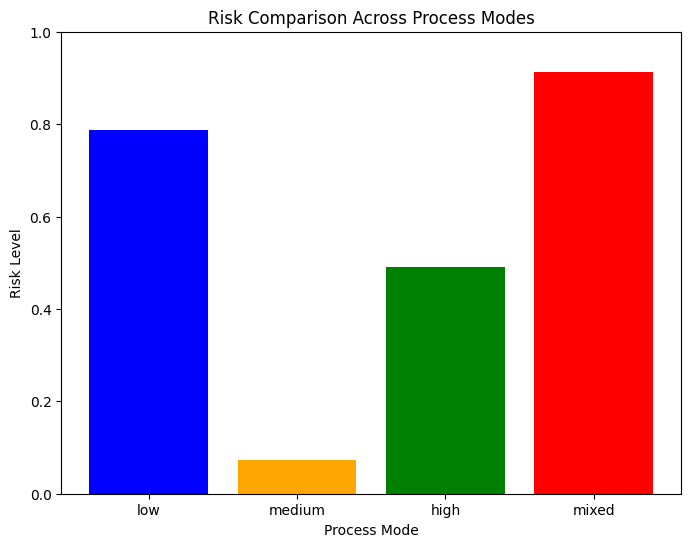

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to compute risk for a given process
def compute_risk(process):
    return np.random.uniform(0, 1)  # Random risk value between 0 and 1

# Define process modes
modes = ['low', 'medium', 'high', 'mixed']

# Generate random risk values
risks = [compute_risk(mode) for mode in modes]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(modes, risks, color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Process Mode")
plt.ylabel("Risk Level")
plt.title("Risk Comparison Across Process Modes")
plt.ylim(0, 1)

# Save the figure
plt.savefig("risk_comparison_chart.png", dpi=300, bbox_inches='tight')

# Show the figure (optional)
plt.show()


C:\Users\ctewa\AppData\Local\Temp\ipykernel_14420\2628346898.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)
C:\Users\ctewa\AppData\Local\Temp\ipykernel_14420\2628346898.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)
C:\Users\ctewa\AppData\Local\Temp\ipykernel_14420\2628346898.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)
C:\Users\ctewa\AppData\Local\Temp\ipykernel_14420\2628346898.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)


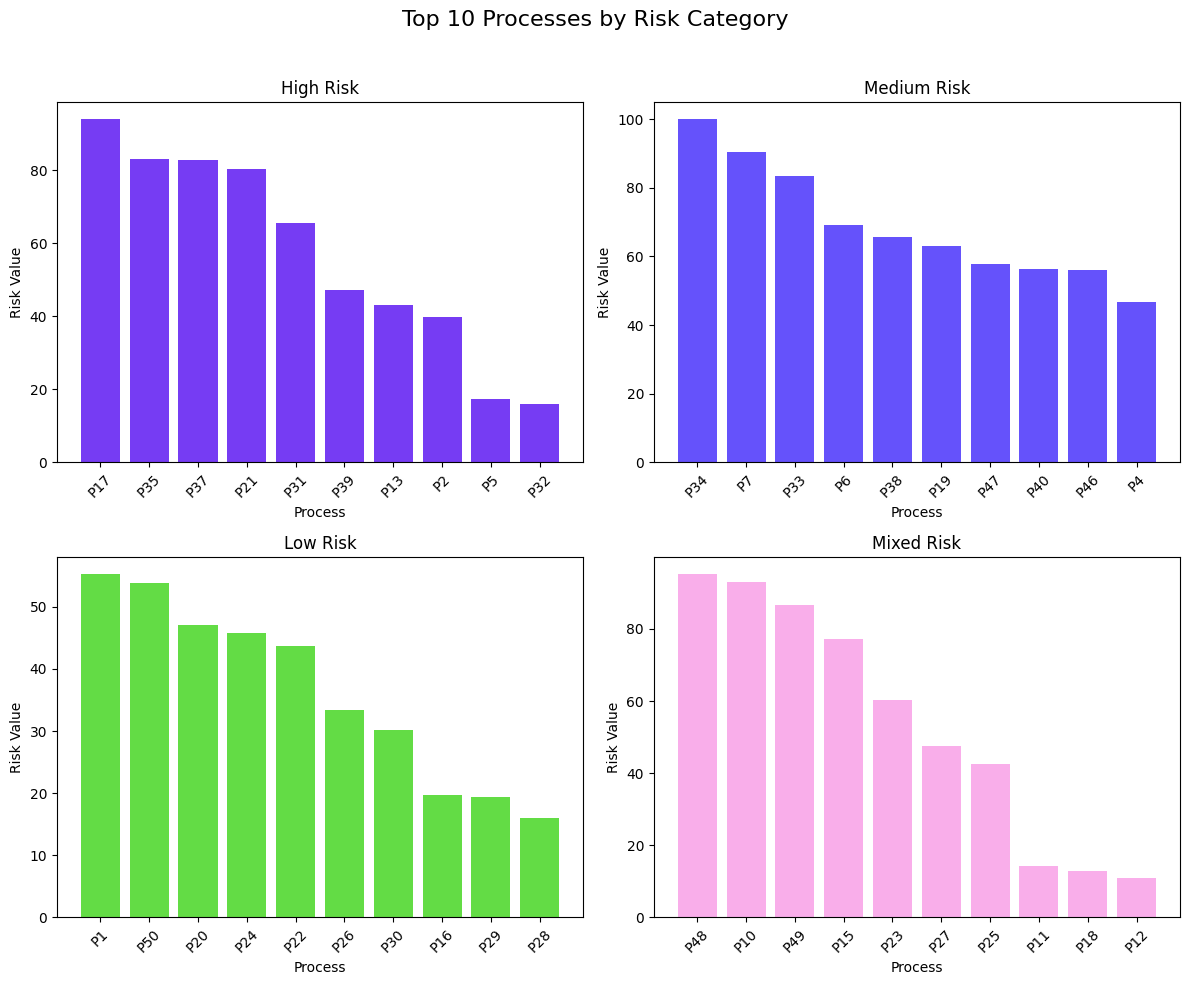

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame (Replace with actual data loading)
data = {
    'Process': [f'P{i}' for i in range(1, 51)],
    'Risk Value': np.random.rand(50) * 100,  # Random risk values between 0 and 100
    'Risk Mode': np.random.choice(['High', 'Medium', 'Low', 'Mixed'], 50)
}
df = pd.DataFrame(data)

# Sort and get the top 10 for each risk mode
categories = ['High', 'Medium', 'Low', 'Mixed']
top_processes = {}
for category in categories:
    top_processes[category] = df[df['Risk Mode'] == category].nlargest(10, 'Risk Value')

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Top 10 Processes by Risk Category', fontsize=16)

for ax, category in zip(axes.flatten(), categories):
    sub_df = top_processes[category]
    if not sub_df.empty:
        ax.bar(sub_df['Process'], sub_df['Risk Value'], color=np.random.rand(3,))
        ax.set_title(f'{category} Risk')
        ax.set_xlabel('Process')
        ax.set_ylabel('Risk Value')
        ax.set_xticklabels(sub_df['Process'], rotation=45)
    else:
        ax.set_title(f'No {category} Risk Processes Found')
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


C:\Users\ctewa\AppData\Local\Temp\ipykernel_14124\3818639780.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)
C:\Users\ctewa\AppData\Local\Temp\ipykernel_14124\3818639780.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)
C:\Users\ctewa\AppData\Local\Temp\ipykernel_14124\3818639780.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)
C:\Users\ctewa\AppData\Local\Temp\ipykernel_14124\3818639780.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df['Process'], rotation=45)


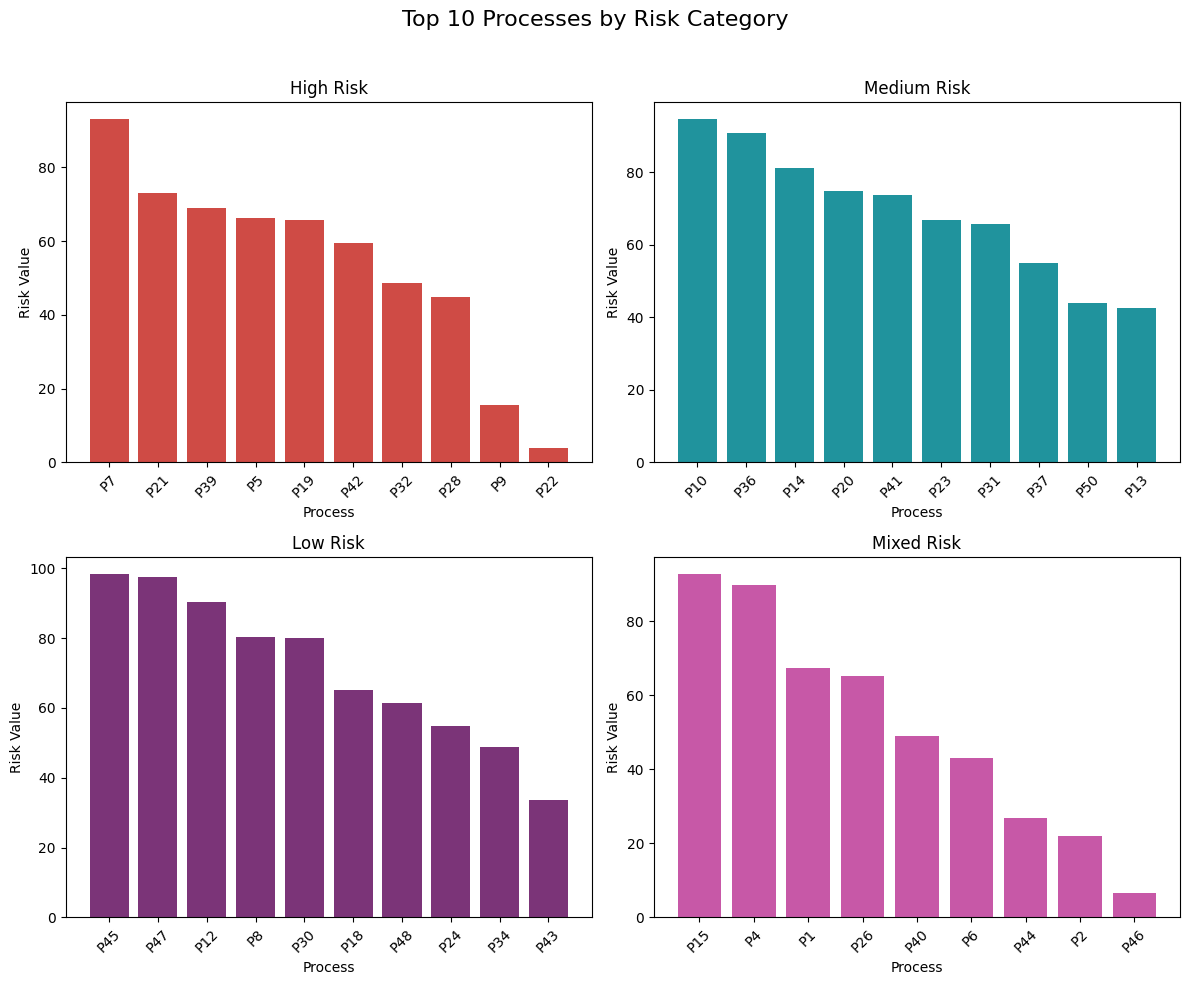

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame (Replace with actual data loading)
data = {
    'Process': [f'P{i}' for i in range(1, 51)],
    'Risk Value': np.random.rand(50) * 100,  # Random risk values between 0 and 100
    'Risk Mode': np.random.choice(['High', 'Medium', 'Low', 'Mixed'], 50)
}
df = pd.DataFrame(data)

# Sort and get the top 10 for each risk mode
categories = ['High', 'Medium', 'Low', 'Mixed']
top_processes = {}
for category in categories:
    top_processes[category] = df[df['Risk Mode'] == category].nlargest(10, 'Risk Value')

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Top 10 Processes by Risk Category', fontsize=16)

for ax, category in zip(axes.flatten(), categories):
    sub_df = top_processes[category]
    if not sub_df.empty:
        ax.bar(sub_df['Process'], sub_df['Risk Value'], color=np.random.rand(3,))
        ax.set_title(f'{category} Risk')
        ax.set_xlabel('Process')
        ax.set_ylabel('Risk Value')
        ax.set_xticklabels(sub_df['Process'], rotation=45)
    else:
        ax.set_title(f'No {category} Risk Processes Found')
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot to a file
plt.savefig('top_10_processes_by_risk_category.png', dpi=300, bbox_inches='tight')

# Optionally, you can still display the plot if you want
plt.show()

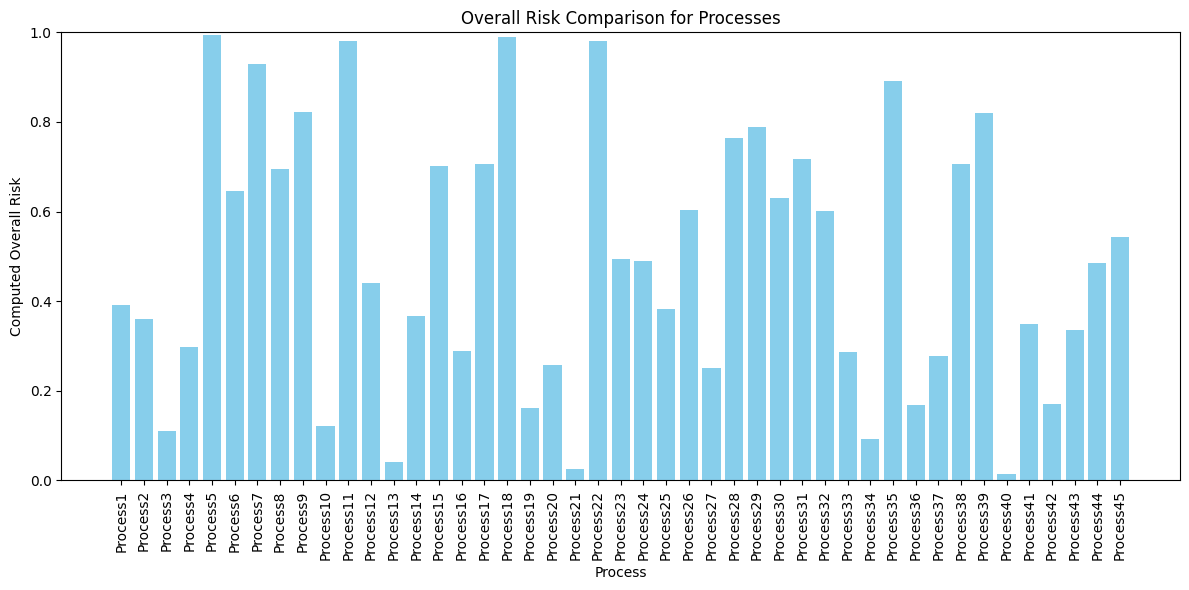

In [6]:
import matplotlib.pyplot as plt
import random

# Placeholder function to compute risk (replace with your actual logic)
def compute_risk(process_expr):
    # For demonstration, return a random risk value between 0 and 1
    return random.uniform(0, 1)

# Define your process strings
processes = {
    "Process1": "(((T1 , ((T2 , (T3 , T4)) ^[p1] (T5 ^[p2] T6))) , ((T7 , (T8 || T9)) || T10)) ^[p3] ((T11 ^[p4] T12) || T13))",
    "Process2": "(((T1 || (T2 ^[p1] T3)) || T4) || ((T5 ^[p2] (T6 ^[p3] T7)) ^[p4] T8))",
    "Process3": "((((T1 ^[p1] T2) , T3) ^[p2] ((T4 || (T5 ^[p3] T6)) , (T7 ^[p4] T8))) || ((T9 , (T10 ^[p5] T11)) || (T12 ^[p6] T13)))",
    "Process4": "(((T1 ^[p1] (T2 , T3)) ^[p2] ((T4 , T5) || T6)) ^[p3] (((T7 ^[p4] T8) , (T9 ^[p5] (T10 ^[p6] (T11 ^[p7] T12)))) , (((T13 || T14) || ((T15 , (T16 ^[p8] T17)) || (T18 ^[p9] T19))) , T20)))",
    "Process5": "(((((T1 , (T2 || T3)) || T4) , ((T5 , T6) , T7)) , (((T8 , (T9 || T10)) ^[p1] ((T11 , T12) ^[p2] (T13 ^[p3] T14))) , T15)) , (((T16 , T17) || (((((T18 || T19) ^[p4] T20) , T21) , (T22 ^[p5] T23)) ^[p6] (T24 ^[p7] T25))) || (((T26 || ((T27 || T28) || T29)) ^[p8] (T30 , T31)) , T32)))",
    "Process6": "(((((T1 , T2) , T3) ^[p1] ((T4 , T5) , T6)) || ((T7 || T8) || T9)) || (((((T10 ^[p2] T11) || (T12 , (T13 ^[p3] T14))) ^[p4] T15) , (T16 ^[p5] T17)) , T18))",
    "Process7": "((((T1 || T2) , (T3 || T4)) || ((T5 , T6) ^[p1] T7)) || (((T8 || ((T9 || T10) ^[p2] T11)) , ((((T12 , T13) , (T14 ^[p3] T15)) , T16) , ((T17 || T18) ^[p4] T19))) , ((T20 , T21) , (T22 , T23))))",
    "Process8": "(((T1 ^[p1] (T2 , T3)) ^[p2] ((T4 , T5) || T6)) ^[p3] (((T7 ^[p4] T8) , (T9 ^[p5] (T10 ^[p6] (T11 ^[p7] T12)))) , (((T13 || T14) || ((T15 , (T16 ^[p8] T17)) || (T18 ^[p9] T19))) , T20)))",
    "Process9": "(((((T1 , T2) , T3) , (T4 ^[p1] T5)) , (((T6 || (T7 ^[p2] T8)) , (T9 , T10)) , T11)) , ((T12 , T13) , T14))",
    "Process10": "((T1 || ((T2 , T3) , ((((T4 ^[p1] T5) || T6) ^[p2] (T7 || ((T8 , T9) ^[p3] T10))) || ((((T11 , T12) || (T13 ^[p4] T14)) , ((T15 || (T16 || T17)) ^[p5] T18)) ^[p6] T19)))) ^[p7] (T20 || ((T21 , T22) ^[p8] (T23 , (T24 ^[p9] ((T25 , T26) || T27))))))",
   "Process11" : "(((T1 ^[p1] T2) , T3) , ((T4 ^[p2] (T5 ^[p3] T6)) , T7))",
   "Process12" : "((T1 || (T2 ^[p1] (T3 ^[p2] T4))) , (T5 || ((T6 , T7) , ((T8 || T9) , T10))))",
   "Process13" : "(((T1 ^[p1] (T2 , T3)) , T4) ^[p2] ((T5 ^[p3] (T6 ^[p4] T7)) ^[p5] (T8 , T9)))",
   "Process14" : "(((((T1 , T2) || T3) , ((T4 || T5) || (T6 || T7))) , T8) || ((((T9 || T10) , ((T11 ^[p1] T12) ^[p2] T13)) || (T14 , (((((T15 , T16) ^[p3] T17) || (T18 || T19)) || ((T20 , ((T21 ^[p4] T22) || T23)) ^[p5] (T24 , (T25 , (((T26 || (T27 || T28)) , (T29 , T30)) ^[p6] (T31 ^[p7] T32)))))) , (T33 ^[p8] T34)))) ^[p9] (T35 , (T36 , T37))))",
   "Process15" : "((((T1 ^[p1] T2) , (T3 , T4)) , T5) ^[p2] T6)",
"Process16" : "((((T1 , T2) || ((T3 ^[p1] T4) || T5)) || (((T6 || T7) , T8) ^[p2] (T9 || T10))) || (T11 || (T12 || T13)))",

"Process17" : "(((T1 , ((T2 , (T3 , T4)) ^[p1] (T5 ^[p2] T6))) , ((T7 , (T8 || T9)) || T10)) ^[p3] ((T11 ^[p4] T12) || T13))",

"Process18" : "((T1 || (T2 ^[p1] (T3 ^[p2] T4))) , (T5 || ((T6 , T7) , ((T8 || T9) , T10))))",
"Process19" : "(((T1 , T2) ^[p1] (T3 , T4)) , ((((((T5 ^[p2] T6) , T7) || T8) ^[p3] T9) || (T10 ^[p4] T11)) ^[p5] T12))",

"Process20" : "(((T1 ^[p1] (T2 , T3)) ^[p2] ((T4 , T5) || T6)) ^[p3] (((T7 ^[p4] T8) , (T9 ^[p5] (T10 ^[p6] (T11 ^[p7] T12)))) , (((T13 || T14) || ((T15 , (T16 ^[p8] T17)) || (T18 ^[p9] T19))) , T20)))",

"Process21" : "((((T1 , T2) ^[p1] (((T3 ^[p2] T4) , (T5 , ((T6 , T7) ^[p3] T8))) || ((T9 , (T10 ^[p4] T11)) , T12))) ^[p5] (((T13 , T14) ^[p6] T15) , T16)) || (T17 , T18))",

"Process22" : "((T1 || T2) ^[p1] (((T3 ^[p2] T4) || (T5 , T6)) || ((T7 , (T8 , T9)) , ((T10 || T11) , T12))))",

"Process23" : "((T1 ^[p1] T2) , (((T3 ^[p2] T4) ^[p3] (((T5 || (T6 || T7)) , (T8 , (T9 || T10))) || (((T11 , T12) , (T13 || T14)) , T15))) , (T16 || (T17 ^[p4] T18))))",

"Process24" : "((T1 , ((((T2 ^[p1] T3) || (((T4 , T5) || (T6 , T7)) , T8)) , (T9 , (T10 , (((T11 , T12) || T13) || T14)))) || ((T15 ^[p2] (T16 , T17)) || (T18 || ((T19 || ((T20 ^[p3] (T21 || T22)) , (T23 || T24))) , (T25 , T26)))))) || (((T27 , T28) || ((T29 , T30) , T31)) ^[p4] (T32 , (T33 , T34))))",

"Process25" : "(((((T1 ^[p1] T2) || (T3 , T4)) , ((T5 || T6) || (T7 , T8))) , (((T9 ^[p2] T10) , (T11 ^[p3] T12)) , (T13 ^[p4] T14))) ^[p5] (T15 ^[p6] (T16 ^[p7] (T17 ^[p8] ((T18 , T19) , T20)))))",

"Process26" : "((T1 ^[p1] (T2 ^[p2] (T3 , (T4 ^[p3] T5)))) ^[p4] (((((T6 ^[p5] T7) , (T8 || T9)) , ((T10 || T11) , T12)) , (T13 ^[p6] T14)) ^[p7] T15))",

"Process27" : "((((T1 , ((T2 ^[p1] (T3 , T4)) , (((T5 , T6) , T7) , (((T8 , T9) , (T10 , T11)) , T12)))) || (T13 , (((T14 , T15) , T16) ^[p2] T17))) , T18) , (T19 ^[p3] T20))",

"Process28" : "(((T1 , T2) , (T3 ^[p1] ((T4 ^[p2] T5) , ((T6 , T7) || T8)))) ^[p3] ((((T9 || T10) , (T11 , T12)) ^[p4] ((T13 , T14) , T15)) , (T16 || ((T17 || T18) || T19))))",

"Process29" : "(((T1 , T2) ^[p1] (((T3 ^[p2] T4) , T5) , (T6 ^[p3] T7))) || ((((T8 || T9) || (T10 , (T11 || T12))) , (((T13 ^[p4] T14) , T15) ^[p5] T16)) , (T17 || (T18 ^[p6] T19))))",

"Process30" : "(((((T1 ^[p1] T2) || (T3 , T4)) , ((T5 || T6) || (T7 , T8))) , (((T9 ^[p2] T10) , (T11 ^[p3] T12)) , (T13 ^[p4] T14))) ^[p5] (T15 ^[p6] (T16 ^[p7] (T17 ^[p8] ((T18 , T19) , T20)))))",

"Process31" : "(((T1 ^[p1] T2) , T3) , ((T4 ^[p2] (T5 ^[p3] T6)) , T7))",

"Process32": "((((T1 , T2) ^[p1] (((T3 ^[p2] T4) , (T5 , ((T6 , T7) ^[p3] T8))) || ((T9 , (T10 ^[p4] T11)) , T12))) ^[p5] (((T13 , T14) ^[p6] T15) , T16)) || (T17 , T18))",

"Process33" : "(((T1 ^[p1] (T2 , T3)) , T4) ^[p2] ((T5 ^[p3] (T6 ^[p4] T7)) ^[p5] (T8 , T9)))",

"Process34" : "(((T1 , T2) ^[p1] (((T3 || (T4 ^[p2] T5)) ^[p3] (T6 || ((T7 || T8) || T9))) , T10)) , ((T11 ^[p4] (T12 ^[p5] (T13 ^[p6] T14))) ^[p7] ((T15 ^[p8] T16) , T17)))",

"Process35" : "((((((T1 || T2) , (T3 || (T4 ^[p1] T5))) , (((T6 , T7) || (T8 , T9)) , ((T10 || T11) , T12))) , ((T13 ^[p2] T14) || (T15 , T16))) ^[p3] T17) || (((T18 , ((T19 ^[p4] T20) , T21)) ^[p5] ((T22 || ((T23 || T24) , T25)) ^[p6] T26)) , (T27 , T28)))",

"Process36" : "((((((T1 ^[p1] T2) ^[p2] T3) , ((((T4 || T5) || T6) , T7) ^[p3] (((T8 || (T9 ^[p4] T10)) , T11) || ((T12 ^[p5] T13) ^[p6] T14)))) || (T15 ^[p7] T16)) , ((T17 , T18) || T19)) , (T20 || T21))",
"Process37" : "((((T1 , T2) || ((T3 ^[p1] T4) || T5)) || (((T6 || T7) , T8) ^[p2] (T9 || T10))) || (T11 || (T12 || T13)))",

"Process38" : "((((T1 || (T2 , (T3 ^[p1] T4))) ^[p2] (T5 , T6)) , T7) , (((((T8 , T9) || (T10 || ((T11 ^[p3] T12) , T13))) || T14) , (T15 , T16)) || (((T17 || T18) || (T19 , T20)) || (T21 || (T22 , ((T23 ^[p4] T24) || T25))))))",

"Process39" : "(((T1 ^[p1] T2) , ((T3 || T4) || ((T5 || (T6 ^[p2] T7)) , T8))) ^[p3] ((T9 || T10) , (T11 || T12)))",

"Process40" : "((T1 ^[p1] ((T2 , (T3 || (T4 , T5))) , (T6 , T7))) || (((T8 , (T9 , T10)) || T11) , (T12 ^[p2] T13)))",

"Process41" : "(((T1 ^[p1] T2) , (T3 ^[p2] T4)) , (((T5 , T6) , (T7 , (T8 ^[p3] T9))) || (T10 || (T11 ^[p4] T12))))",

"Process42" : "((T1 || (T2 || T3)) , (((((T4 || T5) , T6) ^[p1] T7) || (T8 ^[p2] T9)) ^[p3] ((T10 , T11) , (T12 , ((T13 ^[p4] T14) || T15)))))",

"Process43" : "(((T1 ^[p1] (T2 , T3)) , T4) ^[p2] ((T5 ^[p3] (T6 ^[p4] T7)) ^[p5] (T8 , T9)))",

"Process44" : "(((T1 , T2) , ((T3 , T4) ^[p1] (T5 , T6))) || (T7 , ((T8 || T9) , (((T10 ^[p2] T11) , T12) , (T13 ^[p3] T14)))))",

"Process45" : "((T1 || (T2 ^[p1] (T3 ^[p2] T4))) , (T5 || ((T6 , T7) , ((T8 || T9) , T10))))",
}

# Compute risks for each process
process_risks = {process: compute_risk(expr) for process, expr in processes.items()}

# Categorize processes based on risk levels
categorized_processes = {
    'low': {},
    'medium': {},
    'high': {},
    'mixed': {},
}

for process, risk in process_risks.items():
    if risk < 0.33:
        categorized_processes['low'][process] = risk
    elif risk < 0.66:
        categorized_processes['medium'][process] = risk
    else:
        categorized_processes['high'][process] = risk
    categorized_processes['mixed'][process] = risk  # Mixed includes all

# Create a bar chart
plt.figure(figsize=(12, 6))
names = list(process_risks.keys())
values = [process_risks[name] for name in names]
plt.bar(names, values, color='skyblue')
plt.xlabel("Process")
plt.ylabel("Computed Overall Risk")
plt.title("Overall Risk Comparison for Processes")
plt.ylim(0, 1)  # Assuming risk values are between 0 and 1
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
# Save the plot to a file
plt.savefig('Overall Risk Comparison for Processes.png', dpi=300, bbox_inches='tight')
plt.show()